In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
fields = ['Modal_Price', 'Price_Date']
df = pd.read_csv("../Processed_Data/ProSambhajinagarPotato.csv", skipinitialspace=True, usecols=fields)

In [3]:
df['Price_Date'] = pd.to_datetime(df['Price_Date'], errors='coerce')
df = df.set_index('Price_Date')


In [4]:
y = df['Modal_Price'].resample('MS').mean()
y = y.fillna(y.bfill())


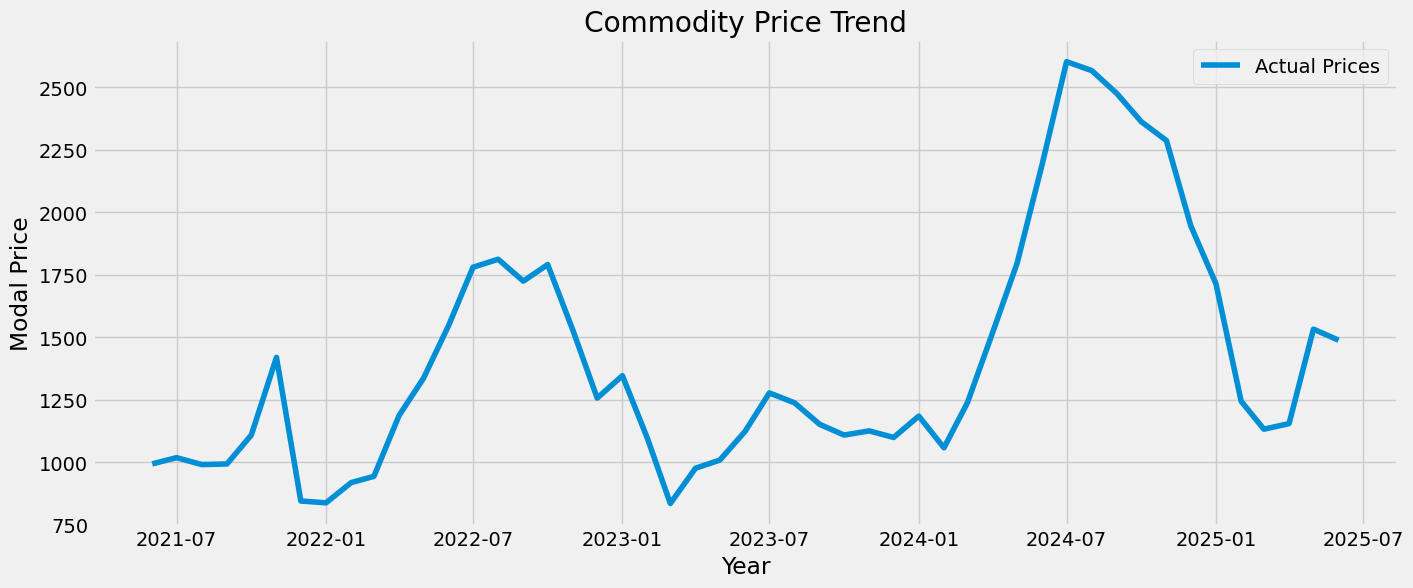

In [5]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(y, label='Actual Prices')
plt.xlabel("Year")
plt.ylabel("Modal Price")
plt.title("Commodity Price Trend")
plt.legend()
plt.show()

In [6]:
# Define ARIMA parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Find best model using AIC
best_aic = float("inf")
best_param = None
best_seasonal_param = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = param_seasonal
        except:
            continue

print(f"Best Model: ARIMA{best_param}x{best_seasonal_param} - AIC: {best_aic}")

Best Model: ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC: 298.1363376126041


In [7]:
# mod = sm.tsa.statespace.SARIMAX(
#     y,
#     order=best_param,
#     seasonal_order=best_seasonal_param,
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )
# results = mod.fit()

In [8]:
# Predict prices for the full year 2025 (Jan 2025 - Dec 2025)
future_dates = pd.date_range(start='2025-01-01', periods=24, freq='MS')
forecast = results.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean  

# Convert to DataFrame for better visualization
predicted_prices_2025 = pd.DataFrame({'Month': future_dates, 'Predicted Price': forecast_mean.values})
predicted_prices_2025.set_index('Month', inplace=True)

# Display predicted prices
print(predicted_prices_2025)


            Predicted Price
Month                      
2025-01-01      1684.825621
2025-02-01      1552.322361
2025-03-01      1381.115452
2025-04-01      1235.786741
2025-05-01      1123.955951
2025-06-01       830.004957
2025-07-01       677.297044
2025-08-01       298.912447
2025-09-01       238.630114
2025-10-01       325.909197
2025-11-01       629.707208
2025-12-01       714.297757
2026-01-01       957.798180
2026-02-01       852.358194
2026-03-01       703.432487
2026-04-01       571.458617
2026-05-01       472.058023
2026-06-01       176.564062
2026-07-01        16.371547
2026-08-01      -372.091794
2026-09-01      -437.081839
2026-10-01      -357.120262
2026-11-01       -39.843512
2026-12-01        26.799167


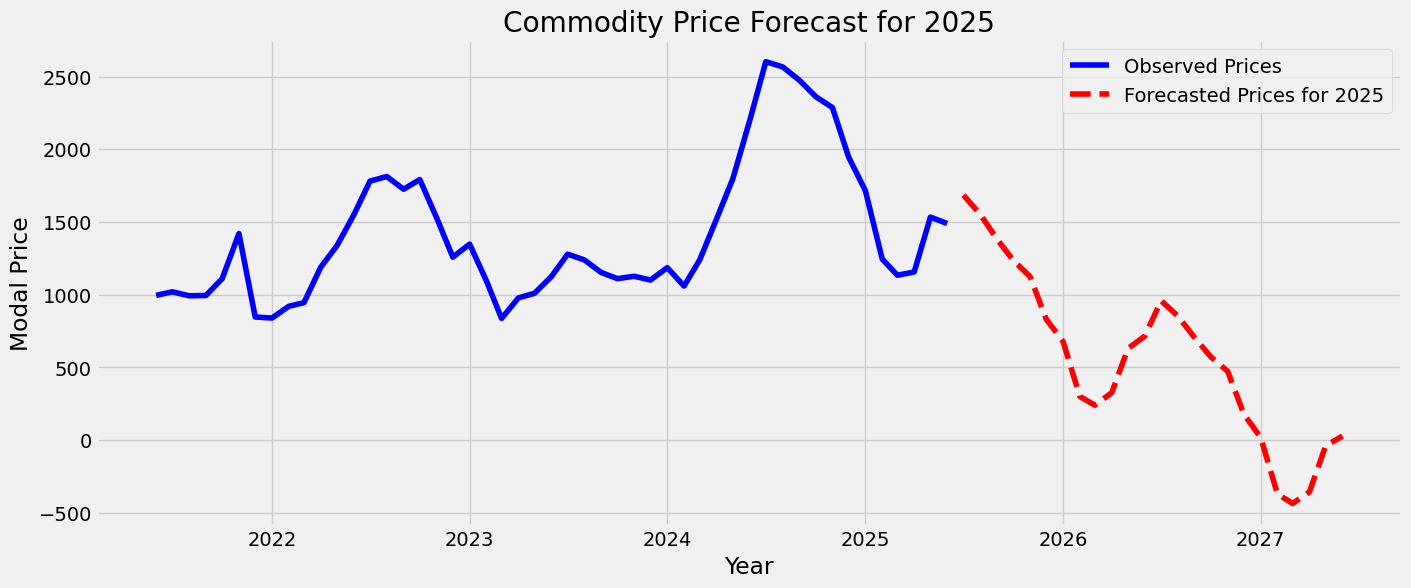

In [9]:
# Plot actual vs predicted prices
plt.figure(figsize=(15, 6))
plt.plot(y, label='Observed Prices', color='blue')
plt.plot(forecast_mean, label='Forecasted Prices for 2025', color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Modal Price")
plt.title("Commodity Price Forecast for 2025")
plt.legend()
plt.show()

In [10]:
predicted_prices_2025.to_csv("./Output/SambhajinagarPotato_Pred.csv")